<a href="https://colab.research.google.com/github/DiMorten/FCN_ConvLSTM_Crop_Recognition_Open_Set/blob/coords5/train_and_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [1]:
!pip install icecream
#%tensorflow_version 1.x
import os
!pip install kora
from kora import drive
import time
!pip install colorama

ds_path='/content/drive/My Drive/PhD/datasets/cv_data/'

     |████████████████████████████████| 57 kB 4.1 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
git_clone = True

if git_clone == True:
  os.chdir('/content')
  %rm -rf FCN_ConvLSTM_Crop_Recognition_Open_Set
  !git clone --branch coords5 https://github.com/DiMorten/FCN_ConvLSTM_Crop_Recognition_Open_Set.git

Cloning into 'FCN_ConvLSTM_Crop_Recognition_Open_Set'...
remote: Enumerating objects: 2189, done.
remote: Counting objects: 100% (2189/2189), done.
remote: Compressing objects: 100% (1618/1618), done.
remote: Total 2189 (delta 1440), reused 1062 (delta 366), pack-reused 0
Receiving objects: 100% (2189/2189), 37.52 MiB | 29.35 MiB/s, done.
Resolving deltas: 100% (1440/1440), done.


## Download images into proper folder

In [4]:
!cp -r /content/drive/MyDrive/PhD/datasets/cv_data /content/FCN_ConvLSTM_Crop_Recognition_Open_Set/dataset/dataset/

In [5]:
os.chdir('/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src')
os.getcwd()
os.listdir()

['mosaic.py.old',
 'postprocessing.py',
 'model_input_mode.py',
 'model_best_UUnet4ConvLSTM_jun_cv_criteria_0_92',
 'densnet_timedistributed.py',
 '__init__.py',
 'keras_weighted_categorical_crossentropy.py',
 'deb.py',
 'model.py',
 'modelArchitecture.py',
 'main.py',
 'patch_extractor.py',
 'parameters',
 'mosaic.py',
 'metrics.py',
 'monitor.py',
 'dataset.py',
 'generator.py',
 'open_set.py',
 'obj',
 'dataSource.py',
 'densnet.py',
 'analysis']

In [6]:
from colorama import init
init()
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Conv2DTranspose
# from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
from tensorflow.keras.optimizers import Adam,Adagrad 
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow.keras as keras

import numpy as np
from sklearn.utils import shuffle
import cv2
import argparse
import tensorflow as tf

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import metrics
import sys
import glob

from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,classification_report
# Local
from densnet import DenseNetFCN
from densnet_timedistributed import DenseNetFCNTimeDistributed

#from metrics import fmeasure,categorical_accuracy
import deb
from keras_weighted_categorical_crossentropy import weighted_categorical_crossentropy, sparse_accuracy_ignoring_last_label, weighted_categorical_crossentropy_ignoring_last_label, categorical_focal_ignoring_last_label, weighted_categorical_focal_ignoring_last_label
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import ConvLSTM2D, UpSampling2D, multiply
from tensorflow.keras.regularizers import l1,l2
import time
import pickle
#from tensorflow.keras_self_attention import SeqSelfAttention
import pdb
import pathlib
from pathlib import Path, PureWindowsPath
from tensorflow.keras.layers import Conv3DTranspose, Conv3D

from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from collections import Counter


#from datagenerator import DataGenerator
from generator import DataGenerator, DataGeneratorWithCoords, DataGeneratorWithCoordsRandom

import matplotlib.pyplot as plt
sys.path.append('../../../dataset/dataset/patches_extract_script/')
from dataSource import DataSource, SARSource, OpticalSource, Dataset, LEM, LEM2, CampoVerde, OpticalSourceWithClouds, Humidity
from model_input_mode import MIMFixed, MIMVarLabel, MIMVarSeqLabel, MIMVarLabel_PaddedSeq, MIMFixedLabelAllLabels, MIMFixed_PaddedSeq
from parameters.parameters_reader import ParamsTrain

from icecream import ic
from monitor import Monitor, MonitorNPY, MonitorGenerator, MonitorNPYAndGenerator
import natsort
from model import NetModel, ModelFit, ModelLoadGeneratorWithCoords
from dataset import Dataset, DatasetWithCoords

from patch_extractor import PatchExtractor
ic.configureOutput(includeContext=False)
np.random.seed(2021)
tf.random.set_seed(2021)

from main import TrainTest

In [7]:
!nvidia-smi

Sun Aug 22 23:03:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set parameters

Parameters can be modified in /content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src/parameters/parameters_reader.py

In [8]:
from pathlib import Path

paramsTrain = ParamsTrain('parameters/')
paramsTrain.mim = MIMFixed_PaddedSeq()

paramsTrain.getFullIms = True
paramsTrain.coordsExtract = True
paramsTrain.train = True

paramsTrain.train_overlap_percentage = 0
paramsTrain.trainGeneratorRandom = False
paramsTrain.patch_len = 32
paramsTrain.stride = int(paramsTrain.patch_len - paramsTrain.patch_len * paramsTrain.train_overlap_percentage)
paramsTrain.patch_step_train = paramsTrain.stride
paramsTrain.patch_step_test = paramsTrain.patch_len # to do: paramsTrain.getCalculatedParams() does these calculations

paramsTrain.dataset = 'cv'
paramsTrain.seq_date = 'jun'
paramsTrain.path = Path("../../../dataset/dataset/") / (paramsTrain.dataset + "_data")

paramsTrain.test_overlap_percentage = 0

paramsTrain.dataSource = SARSource()
paramsTrain.openSetMethod = None
trainTest = TrainTest(paramsTrain)

patchExtractor = PatchExtractor(paramsTrain, trainTest.ds)	

[@debug] parameters_reader.py:115 in __init__()- self.seq_date: 'mar'


self.known_classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


[@debug] parameters_reader.py:174 in __init__()- self.stride: 32


['parameters_reader.py', 'save_nonaugmented_train_patches_unknownclasses.json', 'save_nonaugmented_train_patches.json', 'cv', 'twokkc_parameters_closedset_groupclasses.json', 'twokkc_parameters_openset.json', '__pycache__', 'twokkc_save_nonaugmented_train_patches.json', 'save_nonaugmented_train_patches_lessclass8.json', 'allkkc_save_nonaugmented_train_patches.json', 'params_batchprocessing.py', 'parameters_openset_lessclass8.json', '__init__.py', 'params_reconstruct.py', 'no_mode.json', 'allkkc_parameters_openset.json', 'parameters_openset.json', 'parameters_closedset_groupclasses.json', 'parameters_openset_specifyunknownclasses.json', 'parameters_closedset_groupclasses_lessclass8.json']
[@debug] self.seq_mode = fixed
[@debug] self.mim = <model_input_mode.MIMFixed_PaddedSeq object at 0x7fd425ecec10>
[@debug] self.ds = <dataSource.CampoVerde object at 0x7fd4264cab10>
20151029
20151110
20151122
20151204
20151216
20160121
20160214
20160309
20160321
20160508
20160520
20160613
dotys_sin_cos

[@debug] patch_extractor.py:17 in __init__()
         self.dataSource: <dataSource.SARSource object at 0x7fd425ff8e10>
[@debug] patch_extractor.py:26 in __init__()
         self.conf['path']/self.label_folder/"/": PosixPath('/')
[@debug] patch_extractor.py:35 in __init__()
         self.conf["in_npy_path"]: PosixPath('../../../dataset/dataset/cv_data/in_sar')
[@debug] patch_extractor.py:43 in __init__()
         self.conf["train"]["mask"]["dir"]: PosixPath('../../../dataset/dataset/cv_data/TrainTestMask.tif')
[@debug] patch_extractor.py:44 in __init__()
         os.getcwd(): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'


## Download or load sequence of images


In [9]:
if paramsTrain.getFullIms == True:
  patchExtractor.getFullIms()	
else:
  patchExtractor.fullImsLoad()


[@debug] patch_extractor.py:90 in getFullIms()
         patch["full_ims"].shape: (12, 8492, 7995, 2)
[@debug] patch_extractor.py:91 in getFullIms()
         self.dataset.im_list: ['20151029_S1',
                                '20151110_S1',
                                '20151122_S1',
                                '20151204_S1',
                                '20151216_S1',
                                '20160121_S1',
                                '20160214_S1',
                                '20160309_S1',
                                '20160321_S1',
                                '20160508_S1',
                                '20160520_S1',
                                '20160613_S1']


0 0
[@debug] conf["in_npy_path"]/(im_names[t_step]+".npy") = ../../../dataset/dataset/cv_data/in_sar/20151029_S1.npy
[@debug] patch["full_ims"].dtype = float16
[@debug] np.average(patch["full_ims"][t_step]) = 0.1871337890625
[@debug] np.max(patch["full_ims"][t_step]) = 1.0
[@debug] np.min(patch["full_ims"][t_step]) = 4.172325134277344e-07
../../../dataset/dataset/cv_data/labels/20151029_S1.tif
[@debug] conf["path"]/(self.dataSource.label_folder+"/"+label_names[t_step]+".tif") = ../../../dataset/dataset/cv_data/labels/20151029_S1.tif
[@debug] np.unique(patch["full_label_ims"][t_step],return_counts=True) = (array([ 0,  1,  2,  6,  7,  8,  9, 10, 11], dtype=int8), array([61778564,    45178,    51808,   131138,   438371,   155189,
        5136068,     1007,   156217]))
1 0
[@debug] conf["in_npy_path"]/(im_names[t_step]+".npy") = ../../../dataset/dataset/cv_data/in_sar/20151110_S1.npy
[@debug] patch["full_ims"].dtype = float16
[@debug] np.average(patch["full_ims"][t_step]) = 0.180419921875


[@debug] dataSource.py:369 in im_load()
         patch["full_ims"].shape: (12, 8492, 7995, 2)
[@debug] dataSource.py:370 in im_load()
         patch["full_label_ims"].shape: (12, 8492, 7995)
[@debug] dataSource.py:371 in im_load()
         patch["full_ims"].dtype: dtype('float16')
[@debug] dataSource.py:372 in im_load()
         patch["full_label_ims"].dtype: dtype('int8')


[@debug] np.unique(patch['full_label_ims'],return_counts=True) = (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int8), array([741342768,  17247080,   7809932,  12457060,    185790,     51702,
         2462898,   5372125,   1862268,  24044169,     12084,   1874604]))
0.0 1.0 0.1702
[@debug] self.dataset.name = cv
[@debug] self.dataset.scaler_name = cv
[@debug] self.dataset.seq_mode = fixed
[@debug] self.dataset.seq_date = jun
[@debug] self.dataset.scaler_load = False
[@debug] im.shape = (12, 8492, 7995, 2)
[@debug] im_flat[mask_flat==1,:].shape = (38664648, 2)
0.0001407 1.0 0.0779
[@debug] im_norm.shape = (12, 8492, 7995, 2)
FINISHED NORMALIZING, RESULT:
-1.432 51.53 3.117
[@debug] im.shape = (12, 8492, 7995)
[@debug] mask_train.shape = (8492, 7995)
[@debug] im.dtype = uint8
[@debug] mask_train.dtype = uint8
[@debug] im_train.shape = (12, 8492, 7995)
Train masked unique/count [ 0  1  2  3  4  5  6  7  8  9 10 11] [776057832   9399025   4170646   6930141    103494     346

[@debug] patch_extractor.py:127 in getFullIms()
         self.paramsTrain.path / 'full_ims/full_ims_test.npy': PosixPath('../../../dataset/dataset/cv_data/full_ims/full_ims_test.npy')


## Extract coords of image patches

In [10]:

if paramsTrain.coordsExtract == True:
  patchExtractor.extract()

del patchExtractor



STARTED PATCH EXTRACTION
[@debug] gridx.shape = (250,)
[@debug] gridy.shape = (266,)


[@debug] patch_extractor.py:205 in extract()
         coords_train.shape: (4983, 2)
         coords_test.shape: (4626, 2)
[@debug] patch_extractor.py:206 in extract()
         coords_train.dtype: dtype('int64')
[@debug] patch_extractor.py:207 in extract()
         coords_train[0]: array([7568,  656])


## Train


Initializing object...
12 2
[@debug] self.channel_n = 2


[@debug] dataset.py:96 in __init__()- self.class_n: 10


[@debug] self.t_len = 12
Initializing Dataset instance


[@debug] main.py:118 in setData()- self.data.class_n: 10
[@debug] main.py:146 in preprocess()
         self.model_name: '../results/convlstm_results/model/lm/model_best_UUnetConvLSTM_mar_lm_nomode.h5'
[@debug] dataset.py:186 in create_load()
         os.path.dirname(os.path.abspath(__file__)): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'
[@debug] dataset.py:187 in create_load()
         os.getcwd(): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'
[@debug] dataset.py:191 in create_load()
         self.patches['train']['coords'].shape: (4983, 2)
[@debug] dataset.py:284 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                                array([64671486,   710232,  1374508,    31550,   136800,   212701,
                                                                   

[@debug] np.unique(self.full_label_train, return_counts=True) = (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8), array([64671486,   710232,  1374508,    31550,   136800,   212701,
          71804,   617076,      699,    66684]))


[@debug] dataset.py:343 in labelPreprocess()
         self.labels2new_labels: {0: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 11: 9}
         self.new_labels2labels: {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}


Transforming labels2new_labels...
Transformed labels2new_labels. Moving bcknd to last...
[@debug] dict_filename = results/label_translations/new_labels2labels_cv_20160613_S1.pkl
[@debug] self.new_labels2labels = {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}


[@debug] dataset.py:364 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                array([64671486,   710232,  1374508,    31550,   136800,   212701,
                                                                         71804,   617076,      699,    66684]))


Moved bcknd to last


[@debug] dataset.py:373 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                array([  710232,  1374508,    31550,   136800,   212701,    71804,
                                                                        617076,      699,    66684, 64671486]))
[@debug] dataset.py:374 in labelPreprocess()
         np.unique(self.full_label_test, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                               array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                                       362633,      308,    89533, 65000618]))
[@debug] dataset.py:377 in labelPreprocess()- self.class_n: 10
[@debug] dataset.py:215 in create_load()
         self.patches['train']['label'].shape: (4983, 32, 32)
[@debug] dataset.py:216 in cr

=== SELECT VALIDATION SET FROM TRAIN SET


[@debug] main.py:159 in preprocess()- self.paramsTrain.val_set: True


[@debug] self.paramsTrain.val_set_mode = random


[@debug] dataset.py:402 in val_set_get()
         self.patches['train']['n']: 4983
         self.patches['val']['n']: 747
[@debug] dataset.py:403 in val_set_get()
         self.patches['train']['coords'].shape: (4983, 2)
[@debug] dataset.py:412 in val_set_get()
         self.patches['train']['coords'].shape: (4236, 2)
[@debug] dataset.py:413 in val_set_get()
         self.patches['val']['coords'].shape: (747, 2)
[@debug] main.py:163 in preprocess()
         self.data.patches['val']['coords'].shape: (747, 2)


=== AUGMENTING TRAINING DATA
[@debug] label_type = Nto1
Before balancing:
data.semantic_balance


[@debug] dataset.py:439 in semantic_balance()
         balance["coords"].shape: (6300, 2)
[@debug] dataset.py:443 in semantic_balance()
         np.unique(self.full_label_train, return_counts = True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                  array([  710232,  1374508,    31550,   136800,   212701,    71804,
                                                                          617076,      699,    66684, 64671486]))
[@debug] dataset.py:449 in semantic_balance()
         coords_classes.shape: (4236, 10)
[@debug] dataset.py:451 in semantic_balance()
         unique_train: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)
[@debug] dataset.py:453 in semantic_balance()- bcknd_idx: 9
[@debug] dataset.py:455 in semantic_balance()- psize: 32
[@debug] dataset.py:468 in semantic_balance()
         patch_count: array([1055., 1820.,   55.,  196.,  352.,  125.,  882.,    6.,  120.,
                                0.])

[@debug] clss = 0


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 1820.0
[@debug] dataset.py:478 in semantic_balance()- clss: 1
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([2416, 1820]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (1820, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 1


[@debug] dataset.py:474 in semantic_balance()- patch_count[clss]: 55.0
[@debug] dataset.py:478 in semantic_balance()- clss: 2
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4181,   55]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (55, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 2


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 196.0
[@debug] dataset.py:478 in semantic_balance()- clss: 3
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4040,  196]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (196, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 3


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 352.0
[@debug] dataset.py:478 in semantic_balance()- clss: 4
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([3884,  352]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (352, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 4


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 125.0
[@debug] dataset.py:478 in semantic_balance()- clss: 5
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4111,  125]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (125, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 5


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 882.0
[@debug] dataset.py:478 in semantic_balance()- clss: 6
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([3354,  882]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (882, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 6


[@debug] dataset.py:474 in semantic_balance()- patch_count[clss]: 6.0
[@debug] dataset.py:478 in semantic_balance()- clss: 7
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4230,    6]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (6, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 7


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 120.0
[@debug] dataset.py:478 in semantic_balance()- clss: 8
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4116,  120]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (120, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 8
Balanced train unique (coords):
[@debug] self.patches['train']['coords'].shape = (6300, 2)
[@debug] self.data.patches['train']['coords'].shape = (6300, 2)
Initializing object...
12 2
[@debug] self.channel_n = 2
[@debug] self.t_len = 12
Initializing Model instance
[@debug] self.mp = {'dense': {'recurrent_filters': 128, 'nb_dense_block': 2, 'growth_rate': 64, 'nb_layers_per_block': 1}, 'unet': {'recurrent_filters': 128, 'filter_size': 16}, 'atrous': {'recurrent_filters': 128, 'filter_size': 16, 'dilation_rate_mode': 'auto', 'dilation_rates': [1, 2, 4, 8]}}
[@debug] self.stop_epoch = 400


[@debug] main.py:132 in setModel()
         self.model.name: PosixPath('../results/convlstm_results/model/lm/../results/convlstm_results/model/lm/model_best_UUnetConvLSTM_mar_lm_nomode.h5')
[@debug] main.py:134 in setModel()- self.model.class_n: 9
[@debug] main.py:135 in setModel()- self.data.class_n: 10


[@debug] self.data.class_n = 10
[@debug] self.t_len = 12
[@debug] self.model_t_len = 12
Instructions for updating:
Colocations handled automatically by placer.
[@debug] K.int_shape(x) = (None, 12, 8, 8, 64)
[@debug] K.int_shape(res2) = (None, 8, 8, 64)
[@debug] K.int_shape(p3) = (None, 8, 8, 64)
[@debug] K.int_shape(d3) = (None, 8, 8, 64)
[@debug] K.int_shape(x) = (None, 12, 16, 16, 32)
[@debug] K.int_shape(res2) = (None, 16, 16, 32)
[@debug] K.int_shape(p2) = (None, 16, 16, 32)
[@debug] K.int_shape(d2) = (None, 16, 16, 32)
[@debug] K.int_shape(x) = (None, 12, 32, 32, 16)
[@debug] K.int_shape(res2) = (None, 32, 32, 16)
[@debug] K.int_shape(p1) = (None, 32, 32, 16)
[@debug] K.int_shape(d1) = (None, 32, 32, 16)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 32, 32,  0              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
[@debug] model.py:243 in train()
         data.patches['train']['coords'].shape: (6300, 2)
[@debug] model.py:248 in train()- data.t_len: 12
[@debug] model.py:249 in train()
         data.full_ims_train.shape: (12, 8492, 7995, 2)
[@debug] model.py:250 in train()- self.model_t_len: 12
[@debug] dataset.py:386 in addPaddingToInput()
         im.shape: (12, 8492, 7995, 2)
[@debug] model.py:256 in train()
         data.full_ims_train.shape: (12, 8492, 7995, 2)
[@debug] model.py:311 in applyFitMethod()- self.class_n: 9
[@debug] model.py:330 in applyFitMethod()
         data.patches['train']['coords'].shape: (6300, 2)
[@debug] model.py:331 in applyFitMethod()
         data.patches['train']['coords'][0:16]: array([[5744, 1488],
                                                  

Epoch 1/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.2291 - accuracy: 0.3700

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
[@debug] generator.py:192 in __len__()- n_batches: 46
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: [67.61 89.79 20.7   5.98 60.15 78.25 57.5   0.   32.74]
 — val_precision: [61.71 89.07 27.16 51.13 58.68 73.61 62.27  0.   30.59]
 — val_recall: [74.76 90.51 16.72  3.17 61.69 83.52 53.41  0.   35.22]
 — mean_f1: 45.857777777777784
oa 72.86
Found best weights at epoch 1
393/393 [==============================] - 59s 97ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.2291 - accuracy: 0.3700 - val_loss: 0.1395 - val_accuracy: 0.2819 - mean_f1: 45.8578
Epoch 2/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.1563 - accuracy: 0.2802

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [72.31 91.32 40.02 50.05 46.26 71.58 60.39  0.   31.13]
 — val_precision: [69.16 89.87 27.23 59.37 67.98 57.35 71.7   0.   22.56]
 — val_recall: [75.75 92.81 75.48 43.25 35.06 95.21 52.16  0.   50.2 ]
 — mean_f1: 51.45111111111111
oa 74.69
Found best weights at epoch 2
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.1563 - accuracy: 0.2802 - val_loss: 0.1173 - val_accuracy: 0.2475 - mean_f1: 51.4511
Epoch 3/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.1266 - accuracy: 0.2101

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [73.5  92.17 56.24 59.17 52.51 81.84 67.93  0.   47.35]
 — val_precision: [80.49 90.86 39.61 45.19 74.35 71.2  74.64  0.   33.21]
 — val_recall: [67.63 93.51 96.91 85.66 40.59 96.22 62.33  0.   82.43]
 — mean_f1: 58.96777777777778
oa 77.9
Found best weights at epoch 3
393/393 [==============================] - 37s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.1266 - accuracy: 0.2101 - val_loss: 0.1017 - val_accuracy: 0.1883 - mean_f1: 58.9678
Epoch 4/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.1033 - accuracy: 0.1749

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [77.51 92.6  78.34 61.92 69.44 85.81 70.89  0.   59.28]
 — val_precision: [81.38 91.61 65.21 47.45 86.34 77.35 77.04  0.   44.66]
 — val_recall: [73.99 93.6  98.07 89.1  58.07 96.34 65.65  0.   88.12]
 — mean_f1: 66.19888888888889
oa 81.43
Found best weights at epoch 4
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.1033 - accuracy: 0.1749 - val_loss: 0.0876 - val_accuracy: 0.1970 - mean_f1: 66.1989
Epoch 5/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0870 - accuracy: 0.1645

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [78.49 93.1  84.72 68.11 78.77 87.67 74.42  0.   64.83]
 — val_precision: [84.79 92.19 74.36 53.51 89.31 80.01 76.67  0.   52.14]
 — val_recall: [73.07 94.03 98.43 93.66 70.45 96.96 72.31  0.   85.7 ]
 — mean_f1: 70.01222222222222
oa 83.66
Found best weights at epoch 5
393/393 [==============================] - 37s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0870 - accuracy: 0.1645 - val_loss: 0.0784 - val_accuracy: 0.1871 - mean_f1: 70.0122
Epoch 6/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0745 - accuracy: 0.1611

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [81.17 93.48 80.66 72.34 85.06 87.27 77.51  0.   64.39]
 — val_precision: [89.7  92.19 68.23 58.49 86.86 78.8  79.09  0.   59.72]
 — val_recall: [74.12 94.8  98.63 94.77 83.34 97.77 75.99  0.   69.87]
 — mean_f1: 71.32
oa 85.59
Found best weights at epoch 6
393/393 [==============================] - 37s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0745 - accuracy: 0.1611 - val_loss: 0.0730 - val_accuracy: 0.1721 - mean_f1: 71.3200
Epoch 7/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0658 - accuracy: 0.1609

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [82.45 94.62 89.26 74.11 88.27 92.83 80.62  0.   69.46]
 — val_precision: [90.05 94.3  81.38 60.21 86.04 88.68 80.22  0.   71.28]
 — val_recall: [76.04 94.94 98.82 96.35 90.62 97.37 81.03  0.   67.73]
 — mean_f1: 74.62444444444446
oa 87.54
Found best weights at epoch 7
393/393 [==============================] - 37s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0658 - accuracy: 0.1609 - val_loss: 0.0654 - val_accuracy: 0.1821 - mean_f1: 74.6244
Epoch 8/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0591 - accuracy: 0.1615

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [85.16 95.47 92.06 76.78 89.27 93.11 84.18  0.   73.39]
 — val_precision: [91.08 95.53 86.14 63.62 88.41 88.8  83.69  0.   72.04]
 — val_recall: [79.97 95.4  98.87 96.8  90.15 97.86 84.67  0.   74.79]
 — mean_f1: 76.60222222222222
oa 89.4
Found best weights at epoch 8
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0591 - accuracy: 0.1615 - val_loss: 0.0594 - val_accuracy: 0.1885 - mean_f1: 76.6022
Epoch 9/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0532 - accuracy: 0.1593

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [85.11 96.29 94.61 76.37 90.4  94.09 85.93  0.   77.97]
 — val_precision: [91.48 97.75 90.78 62.85 90.61 90.3  82.63  0.   71.5 ]
 — val_recall: [79.57 94.87 98.78 97.29 90.19 98.2  89.5   0.   85.72]
 — mean_f1: 77.86333333333333
oa 90.21
Found best weights at epoch 9
393/393 [==============================] - 36s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0532 - accuracy: 0.1593 - val_loss: 0.0582 - val_accuracy: 0.1880 - mean_f1: 77.8633
Epoch 10/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0496 - accuracy: 0.1603

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [86.48 96.63 94.61 77.72 90.25 92.04 87.96  0.   79.4 ]
 — val_precision: [91.82 96.94 90.54 64.55 90.66 86.43 87.39  0.   74.48]
 — val_recall: [81.72 96.32 99.05 97.66 89.84 98.42 88.54  0.   85.02]
 — mean_f1: 78.34333333333333
oa 91.12
Found best weights at epoch 10
393/393 [==============================] - 37s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0496 - accuracy: 0.1603 - val_loss: 0.0553 - val_accuracy: 0.1875 - mean_f1: 78.3433
Epoch 11/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0454 - accuracy: 0.1583

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [87.27 96.78 93.04 81.02 91.55 93.16 87.74  0.   80.23]
 — val_precision: [92.99 97.87 87.95 69.66 90.66 88.57 84.4   0.   79.07]
 — val_recall: [82.21 95.71 98.75 96.83 92.47 98.26 91.35  0.   81.42]
 — mean_f1: 78.97666666666666
oa 91.56
Found best weights at epoch 11
393/393 [==============================] - 36s 92ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0454 - accuracy: 0.1583 - val_loss: 0.0514 - val_accuracy: 0.1884 - mean_f1: 78.9767
Epoch 12/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0421 - accuracy: 0.1590

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [88.85 96.67 92.96 81.85 90.64 94.63 88.52  0.   79.07]
 — val_precision: [92.74 98.17 88.35 70.79 90.23 91.51 85.81  0.   75.39]
 — val_recall: [85.28 95.22 98.09 96.99 91.05 97.97 91.39  0.   83.13]
 — mean_f1: 79.24333333333331
oa 91.96
Found best weights at epoch 12
393/393 [==============================] - 36s 92ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0421 - accuracy: 0.1590 - val_loss: 0.0495 - val_accuracy: 0.1962 - mean_f1: 79.2433
Epoch 13/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0401 - accuracy: 0.1593

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.15 97.81 93.83 83.96 90.65 96.45 90.73  0.   77.43]
 — val_precision: [92.03 98.64 89.39 74.63 94.   94.94 91.34  0.   67.27]
 — val_recall: [90.28 97.   98.73 95.96 87.52 98.02 90.13  0.   91.2 ]
 — mean_f1: 80.22333333333333
oa 93.47
Found best weights at epoch 13
393/393 [==============================] - 37s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0401 - accuracy: 0.1593 - val_loss: 0.0463 - val_accuracy: 0.2097 - mean_f1: 80.2233
Epoch 14/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0373 - accuracy: 0.1571

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.01 97.58 92.57 82.11 91.82 93.08 92.11  0.   84.55]
 — val_precision: [90.75 98.71 87.11 71.71 94.71 88.08 95.47  0.   76.81]
 — val_recall: [93.31 96.47 98.77 96.05 89.1  98.68 88.98  0.   94.03]
 — mean_f1: 80.64777777777778
oa 93.87
Found best weights at epoch 14
393/393 [==============================] - 37s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0373 - accuracy: 0.1571 - val_loss: 0.0450 - val_accuracy: 0.2211 - mean_f1: 80.6478
Epoch 15/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0358 - accuracy: 0.1559

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.34 97.62 92.55 84.92 92.67 95.57 91.98  0.   87.73]
 — val_precision: [93.4  98.35 87.06 75.45 95.07 93.12 92.29  0.   81.66]
 — val_recall: [91.29 96.9  98.77 97.1  90.38 98.16 91.67  0.   94.76]
 — mean_f1: 81.70888888888891
oa 94.25
Found best weights at epoch 15
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0358 - accuracy: 0.1559 - val_loss: 0.0425 - val_accuracy: 0.2057 - mean_f1: 81.7089
Epoch 16/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0339 - accuracy: 0.1572

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.87 96.17 94.65 84.02 91.29 91.87 89.84 82.42]
 — val_precision: [91.54 98.92 90.87 75.21 93.9  85.93 88.3  72.78]
 — val_recall: [92.2  93.56 98.77 95.16 88.81 98.69 91.44 95.01]
 — mean_f1: 80.23666666666668
oa 92.79
393/393 [==============================] - 37s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0339 - accuracy: 0.1572 - val_loss: 0.0456 - val_accuracy: 0.2098 - mean_f1: 80.2367
Epoch 17/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0334 - accuracy: 0.1582

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.12 97.91 91.58 85.78 91.95 93.54 92.97 83.13]
 — val_precision: [93.76 98.77 85.49 76.86 93.52 89.92 93.43 79.87]
 — val_recall: [92.49 97.07 98.61 97.03 90.42 97.46 92.51 86.66]
 — mean_f1: 81.10888888888888
oa 94.58
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0334 - accuracy: 0.1582 - val_loss: 0.0410 - val_accuracy: 0.2080 - mean_f1: 81.1089
Epoch 18/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0312 - accuracy: 0.1584

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.09 97.72 91.42 83.04 93.17 93.75 93.15 88.44]
 — val_precision: [93.39 98.55 84.88 72.25 94.04 89.61 95.03 87.58]
 — val_recall: [92.78 96.91 99.04 97.62 92.32 98.29 91.33 89.33]
 — mean_f1: 81.5311111111111
oa 94.58
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0312 - accuracy: 0.1584 - val_loss: 0.0412 - val_accuracy: 0.2093 - mean_f1: 81.5311
Epoch 19/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0297 - accuracy: 0.1558

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.72 97.84 93.59 84.68 92.98 91.27 93.15 87.76]
 — val_precision: [91.85 98.77 88.93 75.44 93.2  85.27 94.94 84.44]
 — val_recall: [91.59 96.92 98.77 96.49 92.76 98.17 91.43 91.36]
 — mean_f1: 81.44333333333333
oa 94.36
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0297 - accuracy: 0.1558 - val_loss: 0.0406 - val_accuracy: 0.2081 - mean_f1: 81.4433
Epoch 20/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0292 - accuracy: 0.1548

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.46 97.83 93.02 82.73 92.26 94.12 92.8   0.   83.81]
 — val_precision: [93.49 98.83 87.91 72.53 92.27 90.06 93.94  0.   78.71]
 — val_recall: [91.45 96.86 98.77 96.29 92.25 98.56 91.68  0.   89.6 ]
 — mean_f1: 81.00333333333333
oa 94.28
393/393 [==============================] - 36s 92ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0292 - accuracy: 0.1548 - val_loss: 0.0410 - val_accuracy: 0.2042 - mean_f1: 81.0033
Epoch 21/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0275 - accuracy: 0.1526

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.18 96.77 91.68 84.25 92.54 94.67 89.76 81.56]
 — val_precision: [92.52 99.16 85.73 77.98 93.8  91.04 86.95 78.06]
 — val_recall: [91.84 94.5  98.53 91.62 91.31 98.61 92.74 85.38]
 — mean_f1: 80.37888888888888
oa 93.23
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0275 - accuracy: 0.1526 - val_loss: 0.0404 - val_accuracy: 0.2070 - mean_f1: 80.3789
Epoch 22/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0260 - accuracy: 0.1541

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.35 98.32 91.92 85.18 93.85 94.05 94.34 88.46]
 — val_precision: [93.55 98.78 85.96 75.99 95.11 92.15 96.2  85.74]
 — val_recall: [93.14 97.86 98.77 96.89 92.63 96.03 92.55 91.36]
 — mean_f1: 82.16333333333334
oa 95.28
Found best weights at epoch 22
393/393 [==============================] - 37s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0260 - accuracy: 0.1541 - val_loss: 0.0356 - val_accuracy: 0.2114 - mean_f1: 82.1633
Epoch 23/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0253 - accuracy: 0.1553

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.25 98.04 91.29 84.29 92.43 94.56 93.    0.   86.58]
 — val_precision: [94.36 98.84 84.87 74.59 93.16 91.34 93.08  0.   89.03]
 — val_recall: [92.17 97.26 98.77 96.89 91.71 98.01 92.93  0.   84.26]
 — mean_f1: 81.49333333333334
oa 94.73
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0253 - accuracy: 0.1553 - val_loss: 0.0363 - val_accuracy: 0.2045 - mean_f1: 81.4933
Epoch 24/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0256 - accuracy: 0.1525

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.81 98.21 85.2  84.49 92.48 92.67 93.23  0.   87.41]
 — val_precision: [94.22 98.53 74.88 74.96 94.11 87.44 94.02  0.   82.64]
 — val_recall: [89.52 97.88 98.82 96.8  90.91 98.56 92.45  0.   92.77]
 — mean_f1: 80.6111111111111
oa 94.43
393/393 [==============================] - 37s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0256 - accuracy: 0.1525 - val_loss: 0.0379 - val_accuracy: 0.1923 - mean_f1: 80.6111
Epoch 25/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0245 - accuracy: 0.1531

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.46 97.87 95.26 78.29 92.39 90.85 93.25 82.01]
 — val_precision: [94.53 98.62 91.97 65.47 91.19 85.06 93.82 83.63]
 — val_recall: [88.57 97.12 98.8  97.35 93.61 97.49 92.69 80.45]
 — mean_f1: 80.15333333333334
oa 93.9
393/393 [==============================] - 36s 92ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0245 - accuracy: 0.1531 - val_loss: 0.0397 - val_accuracy: 0.1945 - mean_f1: 80.1533
Epoch 26/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0236 - accuracy: 0.1586

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.92 98.47 94.39 85.82 91.91 94.72 94.07 84.32]
 — val_precision: [92.26 98.97 89.84 77.28 93.05 91.59 96.16 86.9 ]
 — val_recall: [93.59 97.98 99.43 96.47 90.8  98.06 92.08 81.9 ]
 — mean_f1: 81.84666666666665
oa 95.09
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0236 - accuracy: 0.1586 - val_loss: 0.0339 - val_accuracy: 0.2196 - mean_f1: 81.8467
Epoch 27/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0216 - accuracy: 0.1558

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.45 98.29 94.65 82.92 92.94 94.45 94.06  0.   87.42]
 — val_precision: [93.64 99.13 90.87 71.88 94.05 90.68 95.28  0.   91.52]
 — val_recall: [93.26 97.47 98.77 97.95 91.86 98.55 92.87  0.   83.68]
 — mean_f1: 82.02
oa 95.1
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0216 - accuracy: 0.1558 - val_loss: 0.0328 - val_accuracy: 0.2138 - mean_f1: 82.0200
Epoch 28/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0208 - accuracy: 0.1553

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.4  98.2  92.61 83.   93.03 94.22 94.43  0.   89.49]
 — val_precision: [93.17 99.33 86.83 72.17 94.08 90.28 95.98  0.   90.31]
 — val_recall: [93.63 97.1  99.22 97.65 92.01 98.52 92.92  0.   88.68]
 — mean_f1: 82.04222222222224
oa 95.12
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0208 - accuracy: 0.1553 - val_loss: 0.0332 - val_accuracy: 0.2196 - mean_f1: 82.0422
Epoch 29/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0202 - accuracy: 0.1570

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.17 98.44 93.74 84.12 93.14 93.21 94.6   0.   86.98]
 — val_precision: [93.31 99.14 89.2  74.09 93.68 88.51 96.26  0.   89.87]
 — val_recall: [93.03 97.75 98.77 97.29 92.6  98.44 92.99  0.   84.26]
 — mean_f1: 81.93333333333334
oa 95.23
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0202 - accuracy: 0.1570 - val_loss: 0.0323 - val_accuracy: 0.2143 - mean_f1: 81.9333
Epoch 30/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0222 - accuracy: 0.1571

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.78 97.94 85.42 82.39 92.96 93.07 93.55 84.77]
 — val_precision: [94.54 98.89 74.71 72.18 93.36 88.3  94.77 78.42]
 — val_recall: [91.09 97.01 99.73 95.95 92.57 98.39 92.37 92.23]
 — mean_f1: 80.32
oa 94.47
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0222 - accuracy: 0.1571 - val_loss: 0.0352 - val_accuracy: 0.1988 - mean_f1: 80.3200
Epoch 31/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0196 - accuracy: 0.1532

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.46 98.03 93.72 86.21 93.57 91.38 93.34  0.   92.26]
 — val_precision: [93.77 98.59 88.85 77.7  93.36 85.08 95.37  0.   92.  ]
 — val_recall: [93.15 97.49 99.15 96.81 93.77 98.69 91.4   0.   92.52]
 — mean_f1: 82.44111111111111
oa 95.07
Found best weights at epoch 31
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0196 - accuracy: 0.1532 - val_loss: 0.0321 - val_accuracy: 0.2091 - mean_f1: 82.4411
Epoch 32/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0185 - accuracy: 0.1557

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.87 98.35 94.06 81.5  94.14 95.58 94.56 88.17]
 — val_precision: [94.95 98.91 89.07 70.31 96.15 93.25 95.81 85.49]
 — val_recall: [92.81 97.8  99.64 96.92 92.21 98.04 93.35 91.03]
 — mean_f1: 82.24777777777778
oa 95.35
393/393 [==============================] - 36s 92ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0185 - accuracy: 0.1557 - val_loss: 0.0314 - val_accuracy: 0.2053 - mean_f1: 82.2478
Epoch 33/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0177 - accuracy: 0.1523

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.63 98.52 94.73 85.48 95.02 94.66 95.22 91.38]
 — val_precision: [93.3  99.27 90.65 75.81 95.52 91.62 97.25 91.07]
 — val_recall: [93.96 97.78 99.19 97.97 94.52 97.91 93.27 91.7 ]
 — mean_f1: 83.18222222222222
oa 95.79
Found best weights at epoch 33
393/393 [==============================] - 36s 92ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0177 - accuracy: 0.1523 - val_loss: 0.0295 - val_accuracy: 0.2144 - mean_f1: 83.1822
Epoch 34/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0170 - accuracy: 0.1551

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.88 98.15 93.67 82.07 92.82 94.12 94.51 86.95]
 — val_precision: [94.11 98.85 88.84 71.31 95.81 90.47 96.25 82.6 ]
 — val_recall: [93.66 97.47 99.05 96.65 90.   98.07 92.82 91.77]
 — mean_f1: 81.79666666666667
oa 95.14
393/393 [==============================] - 36s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0170 - accuracy: 0.1551 - val_loss: 0.0307 - val_accuracy: 0.2111 - mean_f1: 81.7967
Epoch 35/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0196 - accuracy: 0.1535

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [85.74 95.14 89.03 81.55 88.83 94.37 84.9  73.42]
 — val_precision: [89.72 97.97 80.83 73.01 94.8  89.87 79.75 59.22]
 — val_recall: [82.1  92.47 99.09 92.35 83.57 99.34 90.77 96.6 ]
 — mean_f1: 76.99777777777778
oa 89.53
393/393 [==============================] - 37s 93ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0196 - accuracy: 0.1535 - val_loss: 0.0436 - val_accuracy: 0.1887 - mean_f1: 76.9978
Epoch 36/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0192 - accuracy: 0.1566

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.2  98.63 93.27 84.96 93.81 93.42 94.25 91.11]
 — val_precision: [93.28 99.16 87.75 75.49 95.82 89.18 96.01 89.95]
 — val_recall: [93.12 98.1  99.54 97.15 91.89 98.08 92.56 92.31]
 — mean_f1: 82.51666666666667
oa 95.41
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0192 - accuracy: 0.1566 - val_loss: 0.0285 - val_accuracy: 0.2159 - mean_f1: 82.5167
Epoch 37/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0161 - accuracy: 0.1547

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.32 98.43 93.05 84.3  93.55 95.5  95.13 90.95]
 — val_precision: [93.42 99.01 87.97 74.22 94.63 93.12 97.05 90.15]
 — val_recall: [93.22 97.86 98.77 97.54 92.49 98.01 93.28 91.77]
 — mean_f1: 82.69222222222223
oa 95.5
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0161 - accuracy: 0.1547 - val_loss: 0.0280 - val_accuracy: 0.2114 - mean_f1: 82.6922
Epoch 38/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0154 - accuracy: 0.1537

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.43 98.59 94.77 82.71 94.01 93.79 94.98  0.   91.27]
 — val_precision: [93.91 99.17 91.09 71.76 95.13 91.22 96.91  0.   89.26]
 — val_recall: [92.96 98.02 98.75 97.6  92.92 96.51 93.13  0.   93.38]
 — mean_f1: 82.61666666666666
oa 95.52
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0154 - accuracy: 0.1537 - val_loss: 0.0281 - val_accuracy: 0.2142 - mean_f1: 82.6167
Epoch 39/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0148 - accuracy: 0.1540

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.65 98.51 94.34 82.62 93.34 93.79 94.77  0.   91.84]
 — val_precision: [94.43 99.1  90.1  71.9  94.05 89.99 96.3   0.   92.3 ]
 — val_recall: [92.89 97.93 98.99 97.1  92.64 97.91 93.28  0.   91.38]
 — mean_f1: 82.54
oa 95.45
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0148 - accuracy: 0.1540 - val_loss: 0.0282 - val_accuracy: 0.2096 - mean_f1: 82.5400
Epoch 40/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0144 - accuracy: 0.1530

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.02 97.9  92.46 81.23 94.44 94.38 93.78  0.   91.39]
 — val_precision: [93.64 99.08 86.91 69.85 96.75 90.7  94.12  0.   90.83]
 — val_recall: [92.4  96.74 98.77 97.04 92.24 98.38 93.44  0.   91.96]
 — mean_f1: 82.06666666666666
oa 94.84
393/393 [==============================] - 38s 96ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0144 - accuracy: 0.1530 - val_loss: 0.0285 - val_accuracy: 0.2107 - mean_f1: 82.0667
Epoch 41/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0146 - accuracy: 0.1520

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.56 98.31 94.14 83.   94.33 95.02 94.36  0.   91.76]
 — val_precision: [95.05 98.77 89.98 72.28 96.18 92.97 94.85  0.   90.34]
 — val_recall: [92.12 97.85 98.7  97.46 92.56 97.16 93.87  0.   93.23]
 — mean_f1: 82.72
oa 95.38
393/393 [==============================] - 37s 94ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0146 - accuracy: 0.1520 - val_loss: 0.0267 - val_accuracy: 0.2043 - mean_f1: 82.7200
Epoch 42/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0136 - accuracy: 0.1541

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [94.2  98.82 93.25 85.1  93.24 94.6  94.93  0.   92.01]
 — val_precision: [94.84 99.19 87.94 74.91 95.76 90.99 96.14  0.   92.9 ]
 — val_recall: [93.56 98.45 99.24 98.51 90.86 98.52 93.75  0.   91.13]
 — mean_f1: 82.90555555555555
oa 95.85
393/393 [==============================] - 37s 95ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0136 - accuracy: 0.1541 - val_loss: 0.0267 - val_accuracy: 0.2082 - mean_f1: 82.9056
Epoch 43/70
393/393 [==============================] - ETA: 0s - batch: 196.0000 - size: 16.0000 - loss: 0.0132 - accuracy: 0.1548

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [94.04 98.49 89.5  84.71 93.77 95.08 93.83  0.   92.91]
 — val_precision: [94.07 99.15 81.43 75.   94.37 94.13 95.65  0.   93.69]
 — val_recall: [94.01 97.84 99.36 97.31 93.18 96.06 92.07  0.   92.15]
 — mean_f1: 82.48111111111112
oa 95.45
Restoring model weights from the end of the best epoch.
393/393 [==============================] - 38s 98ms/step - batch: 196.0000 - size: 16.0000 - loss: 0.0132 - accuracy: 0.1548 - val_loss: 0.0267 - val_accuracy: 0.2124 - mean_f1: 82.4811
Epoch %05d: early stopping
f1 history [45.857777777777784, 51.45111111111111, 58.96777777777778, 66.19888888888889, 70.01222222222222, 71.32, 74.62444444444446, 76.60222222222222, 77.86333333333333, 78.34333333333333, 78.97666666666666, 79.24333333333331, 80.22333333333333, 80.64777777777778, 81.70888888888891, 80.23666666666668, 81.10888888888888, 81.5311111111111, 81.44333333333333, 81.00333333333333, 80.37888888888888, 82.16333333333334, 81.49333333333334, 80.6111111111111, 80.15333333333334, 81.846

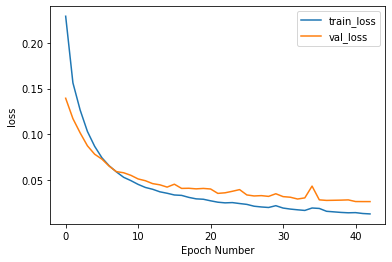

In [11]:
	trainTest.setData()


	trainTest.preprocess(paramsTrain.model_name_id) # move into if

	trainTest.setModel()

	if paramsTrain.train == True:
		trainTest.train()
	else:
		trainTest.modelLoad(paramsTrain.model_name_id)

## Evaluate


In [12]:
paramsMosaic = ParamsReconstruct(paramsTrain)

paramsMosaic.mosaic_flag = True

trainTest.evaluate(paramsMosaic)


[@debug] dataset.py:562 in loadMask()
         str(self.paramsTrain.path): '../../../dataset/dataset/cv_data'
[@debug] dataset.py:564 in loadMask()- self.mask.shape: (8492, 7995)
[@debug] dataset.py:386 in addPaddingToInput()
         im.shape: (12, 8492, 7995, 2)
[@debug] params_reconstruct.py:43 in __init__()
         self.overlap: 0
         self.threshold_idx: 4
[@debug] params_reconstruct.py:43 in __init__()
         self.overlap: 0
         self.threshold_idx: 4
[@debug] mosaic.py:45 in __init__()- paramsTrain.seq_date: 'jun'


[@debug] dataset = cv
[@debug] paramsTrain.model_type = UUnetConvLSTM


[@debug] mosaic.py:133 in create()- self.data.class_n: 10
[@debug] mosaic.py:134 in create()
         np.unique(self.data.full_label_test): array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8)
         len(np.unique(self.data.full_label_test)): 10
[@debug] mosaic.py:135 in create()
         np.unique(self.data.full_label_train): array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)
         len(np.unique(self.data.full_label_train)): 10


FileNotFoundError: ignored